# Analysis de raíces

## Configuración
Las siguientes secciones contienen información que se utilizará más adelante en el código. En la primera parte, se importan todas las bibliotecas necesarias, y en la segunda parte, se desarrolla una función para visualizar las imágenes que se utilizarán más adelante en el código.

In [1]:
# Import libraries
from plantcv import plantcv as pcv 
from plantcv.parallel import WorkflowInputs
from matplotlib import pyplot as plt
from IPython.display import Image, display
import cv2
import numpy as np
pcv.params.debug = "None"

In [2]:
def img_disp(img_to_disp):
    # Display image
    _, img_png = cv2.imencode('.png', cv2.cvtColor(img_to_disp, cv2.COLOR_BGR2RGB))
    display(Image(data=img_png.tobytes(), width=300))

## Preprocesamiento de la imagen
El primer paso en el proceso consiste en cargar la imagen, luego convertirla a escala de grises y binarizarla, es decir, cambiar todos los valores a 0 o 1. Finalmente, se reduce el ruido eliminando las imperfecciones alrededor.

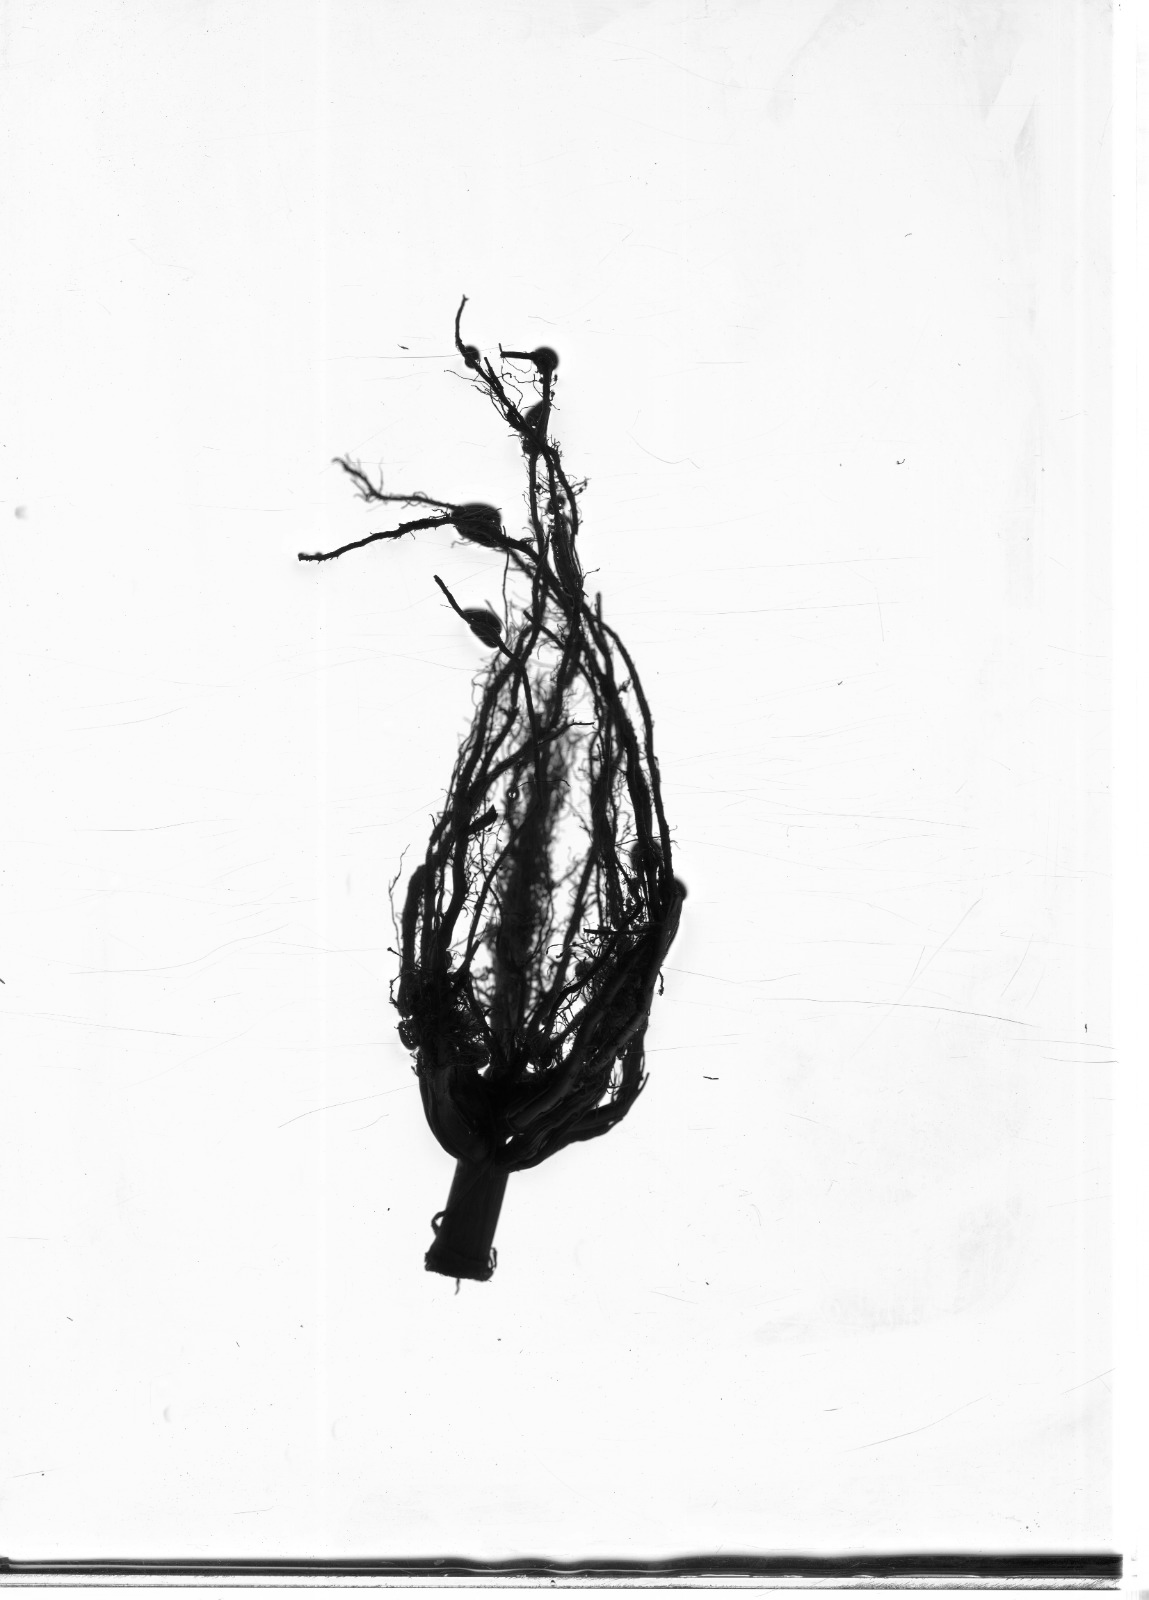

In [3]:
# Load the image 
img = cv2.imread('./data/root1C.jpeg') 

# Image converted from RGB to gray.
gray = pcv.rgb2gray(rgb_img=img)
img_disp(gray)


### Binarizar la imagen
Dependiendo del umbral utilizado para binarizar la imagen, podemos obtener una imagen más gruesa con más información sobre la raíz o más delgada, lo que reduce el ruido alrededor del borde difuso.

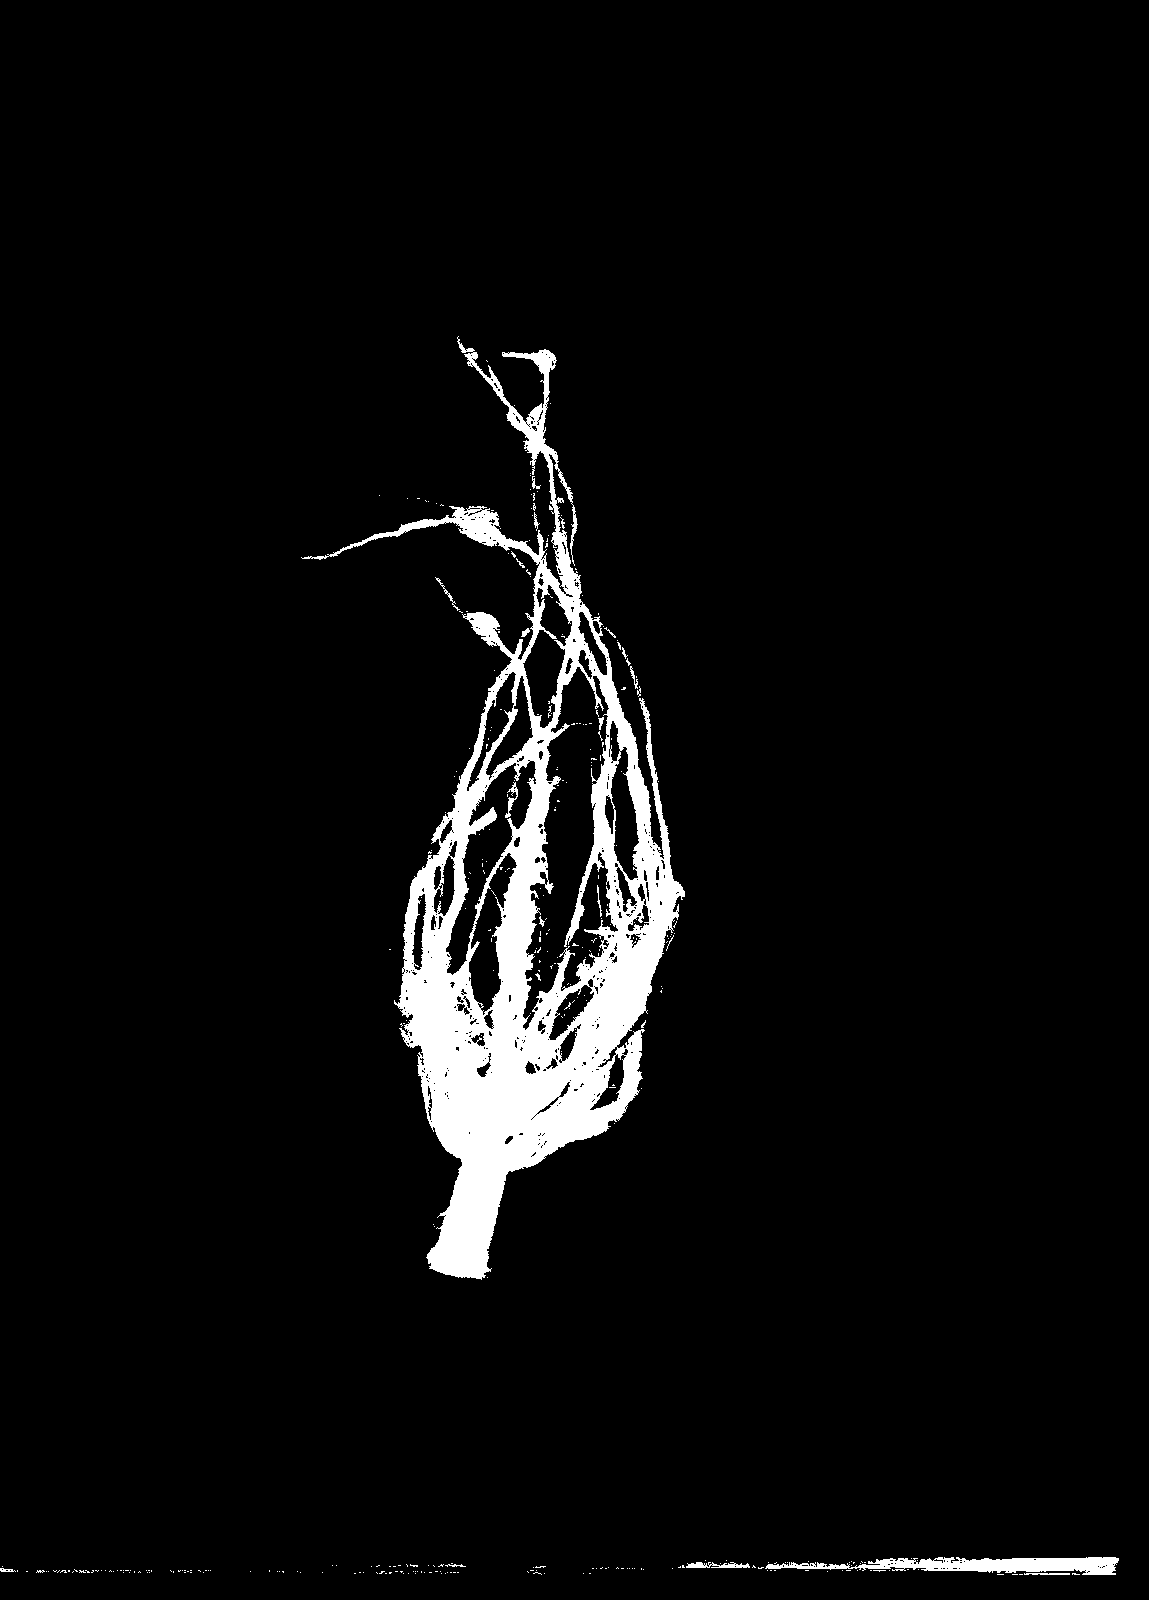

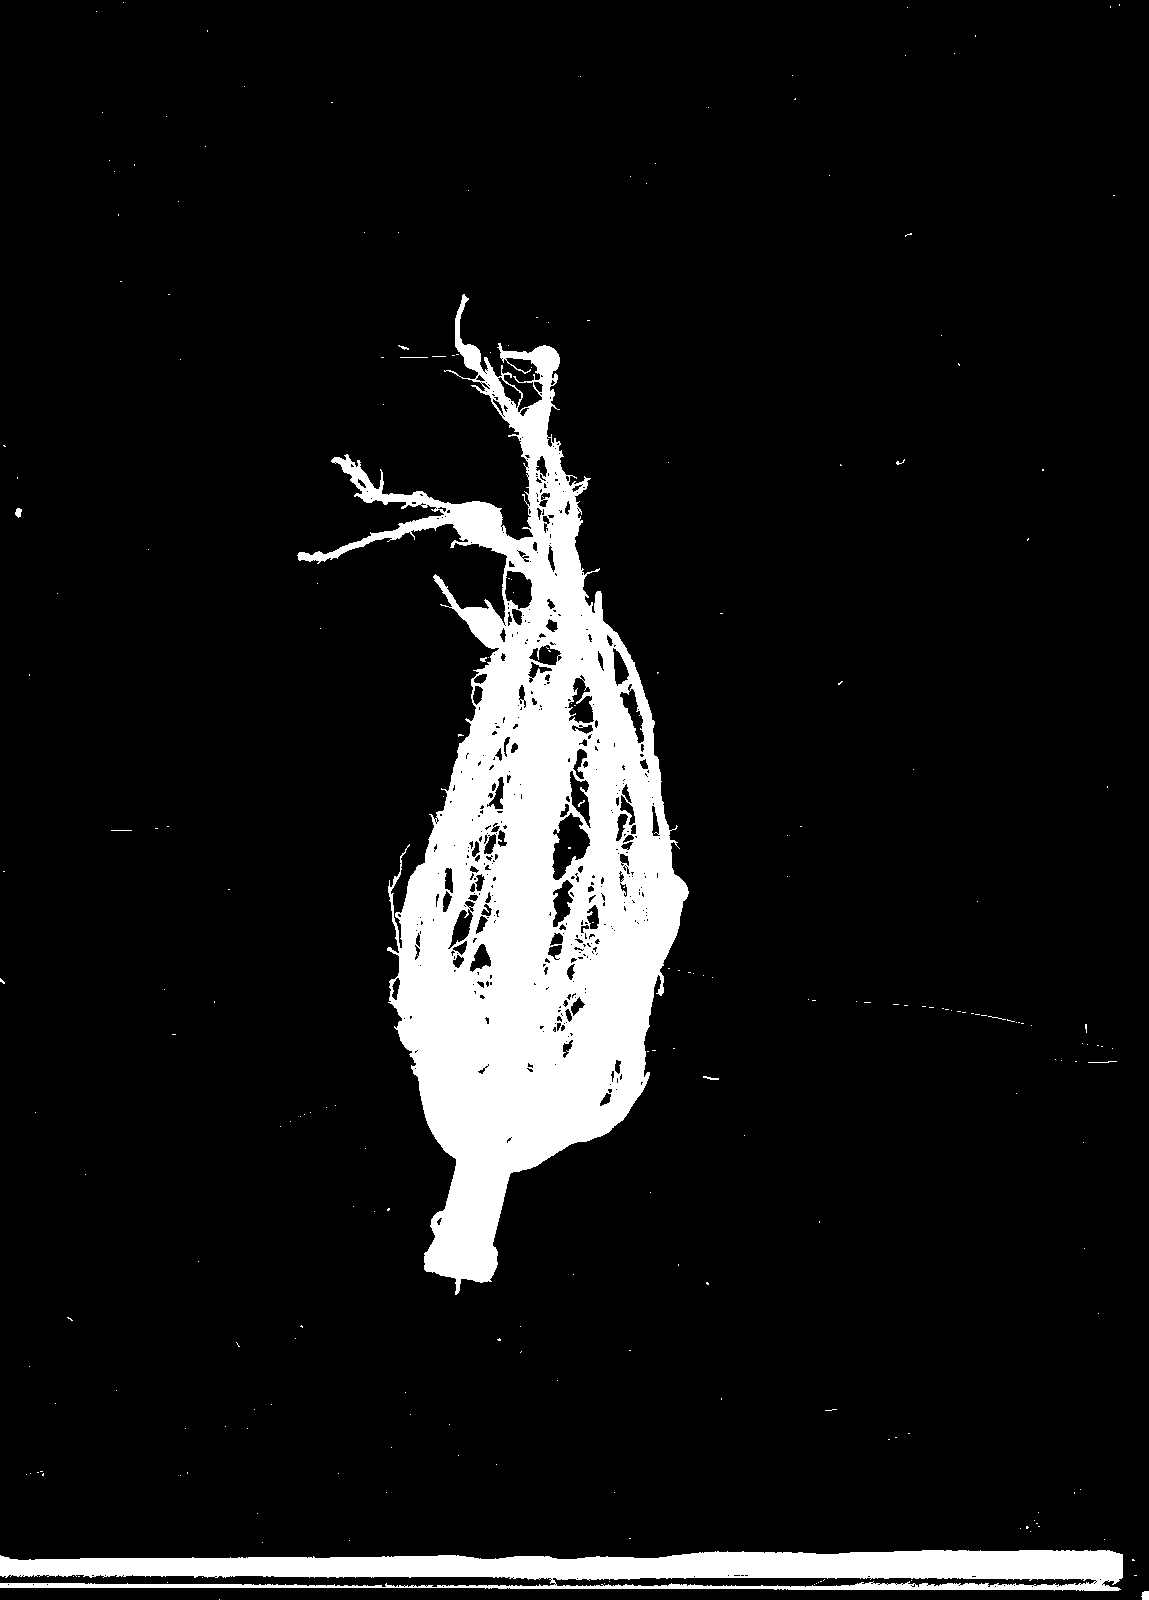

In [4]:
gray_thresh_low = pcv.threshold.binary(gray_img=gray, threshold = 40, object_type='dark')
gray_thresh_high = pcv.threshold.binary(gray_img=gray, threshold = 220, object_type='dark')

# Show images
img_disp(gray_thresh_low)

img_disp(gray_thresh_high)

### Recortar la imagen
No toda la imagen contiene información útil, por lo que es importante recortarla. Por ahora, esto se hace de manera manual, pero es posible desarrollar funciones que realicen este proceso automáticamente, reduciendo el error humano.

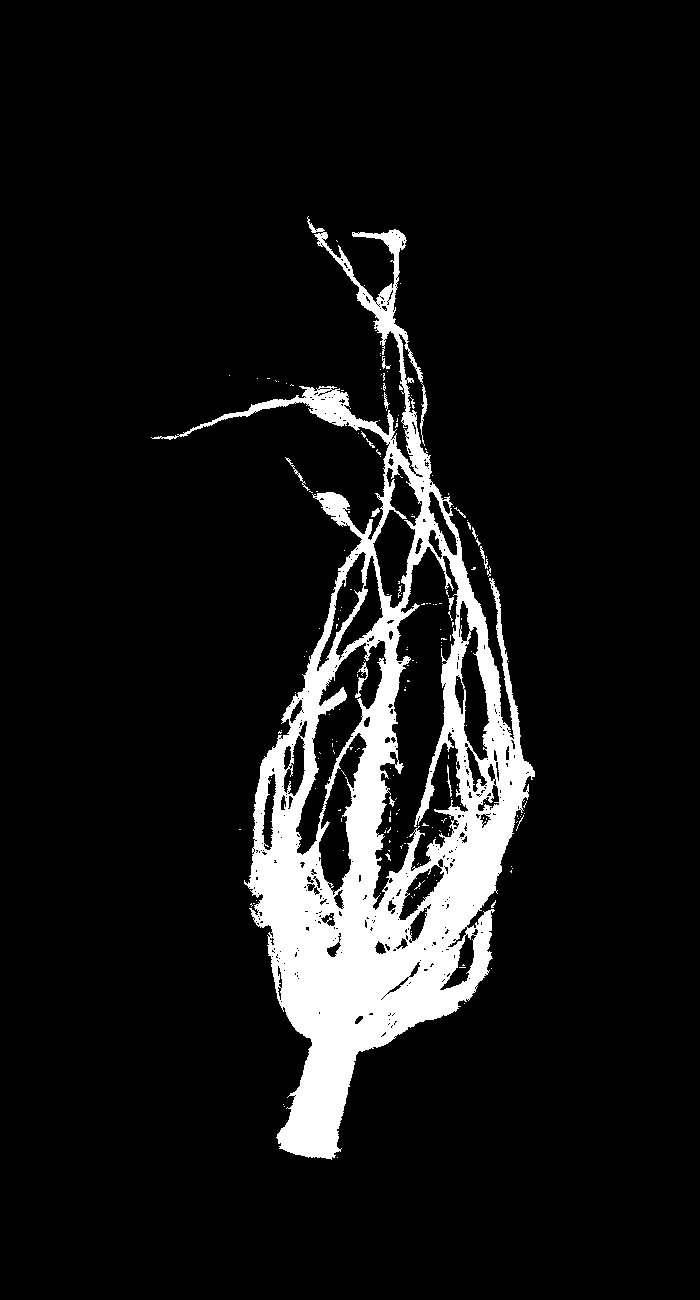

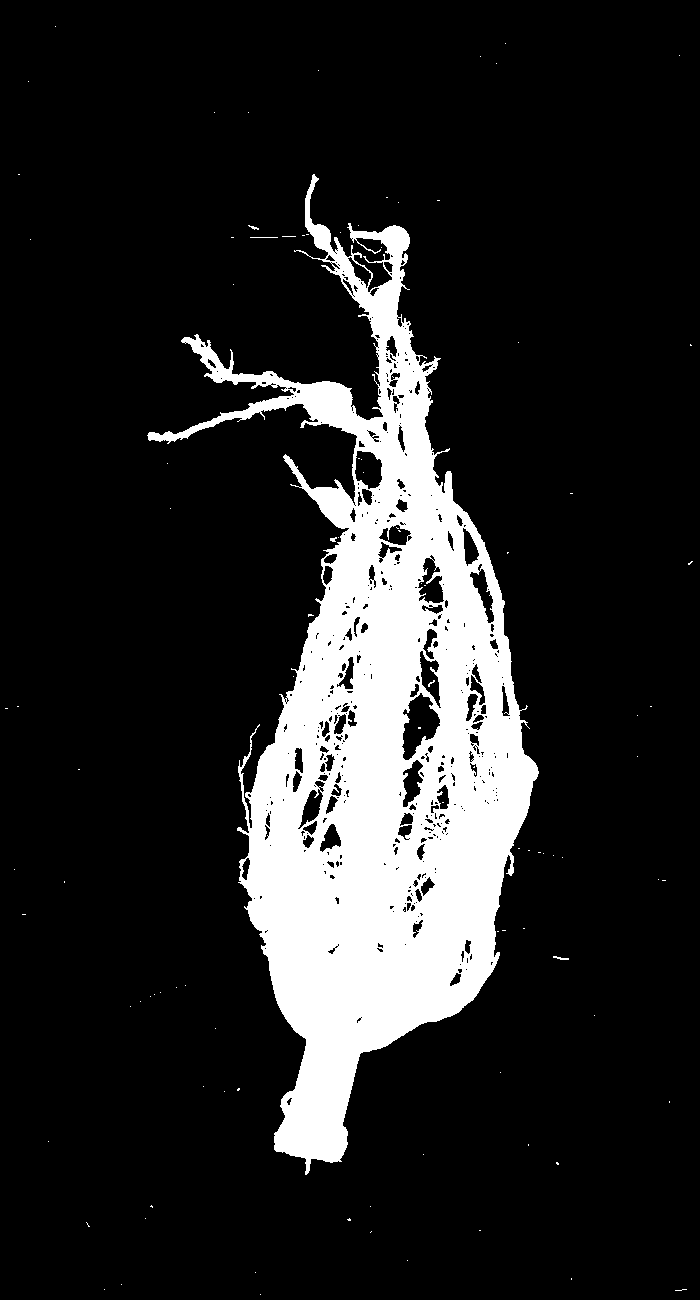

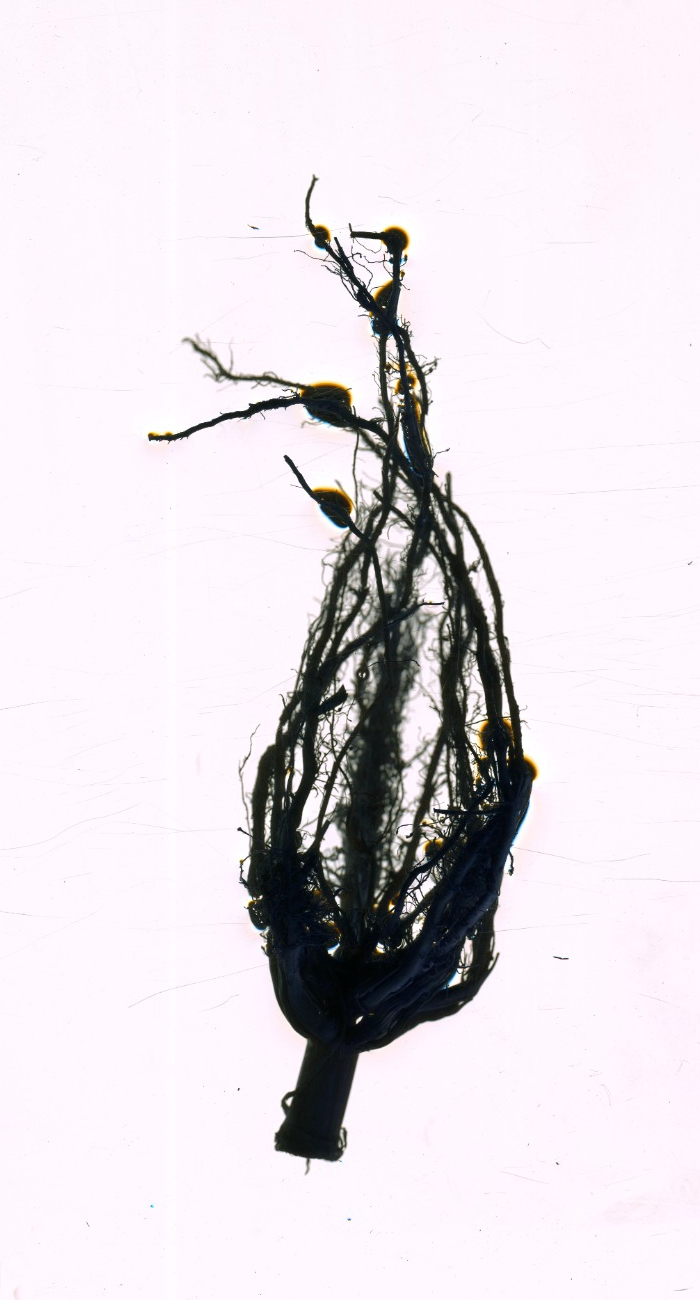

In [5]:
# Crop low threshold
crop_gray_thresh_low = pcv.crop(img=gray_thresh_low, x=150, y=120, h=1300, w=700)
img_disp(crop_gray_thresh_low)

# Crop high threshold
crop_gray_thresh_high = pcv.crop(img=gray_thresh_high, x=150, y=120, h=1300, w=700)
img_disp(crop_gray_thresh_high)

# Crop general image
crop_img = pcv.crop(img=img, x=150, y=120, h=1300, w=700)
img_disp(crop_img)

### Ruido de fondo
Para reducir el ruido de fondo, la imagen se dilata para asegurarnos de que toda la información de la raíz se conserve y cualquier parte de la raíz que pueda estar separada se adjunte correctamente. Después, todas las formas que tienen un tamaño menor a cierta medida, en este caso 100, se eliminan.

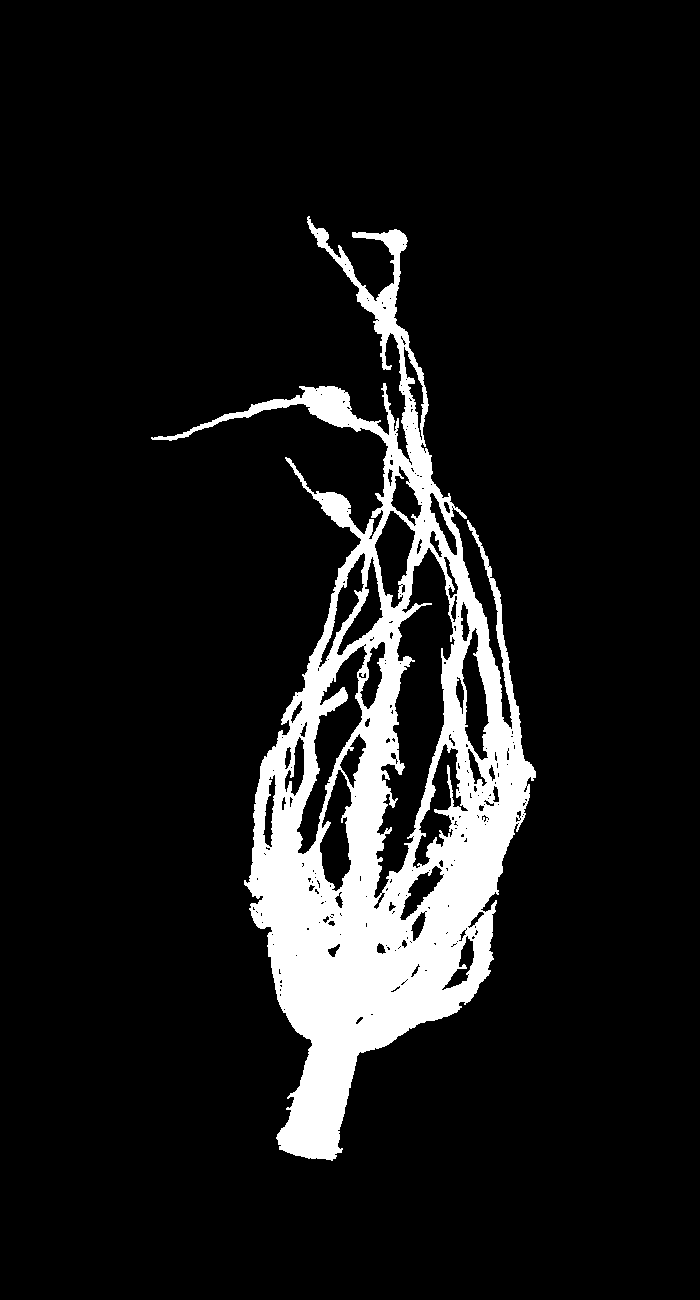

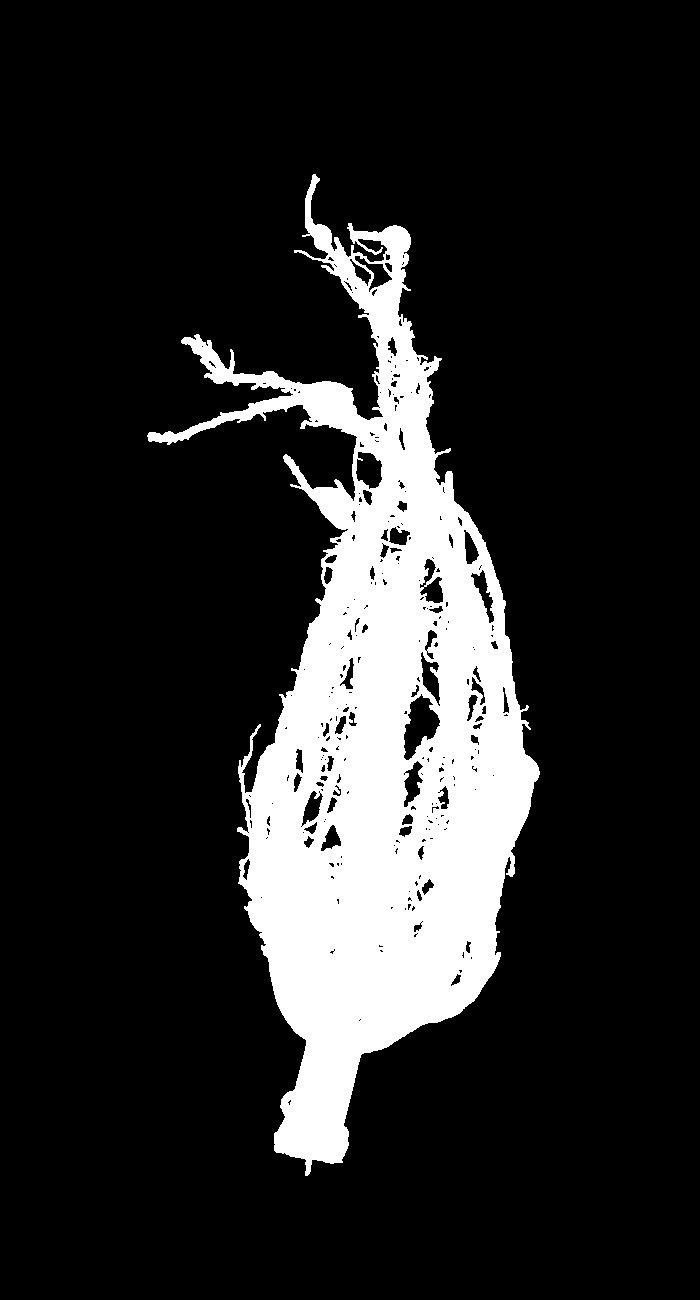

In [6]:
mask_dilated = pcv.dilate(gray_img=crop_gray_thresh_low, ksize=2, i=1)
mask_fill_low = pcv.fill(bin_img=mask_dilated, size=100)
img_disp(mask_fill_low)

mask_dilated = pcv.dilate(gray_img=crop_gray_thresh_high, ksize=2, i=1)
mask_fill_high = pcv.fill(bin_img=mask_dilated, size=100)
img_disp(mask_fill_high)


## Analysis morphologico

### Esqueletizar
Convierte la máscara en un esqueleto de un píxel de ancho, que se puede utilizar para análisis morfológicos. El siguiente paso es podar las ramas. Generalmente, las imágenes esqueletizadas tendrán ramas que representan el ancho del material vegetal, que luego deben podarse. Basándose en los puntos donde el esqueleto se divide, es posible seleccionar diferentes secciones de la imagen y mostrarlas con colores distintos.

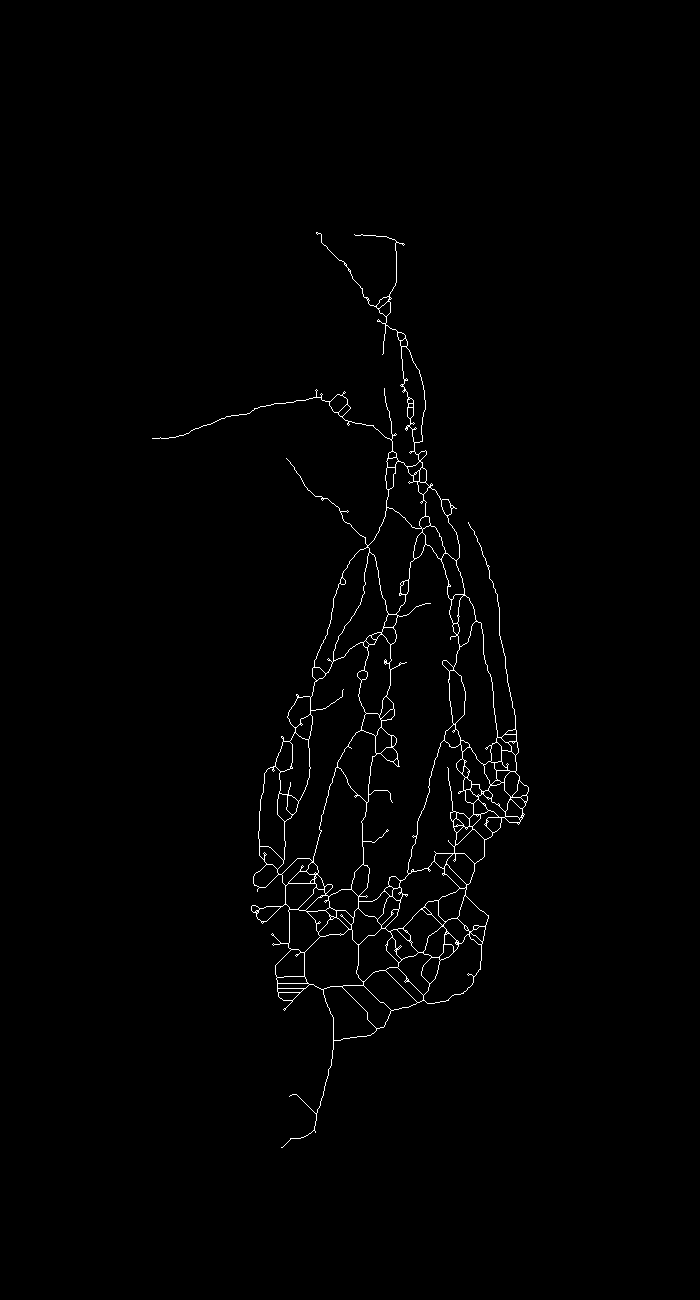

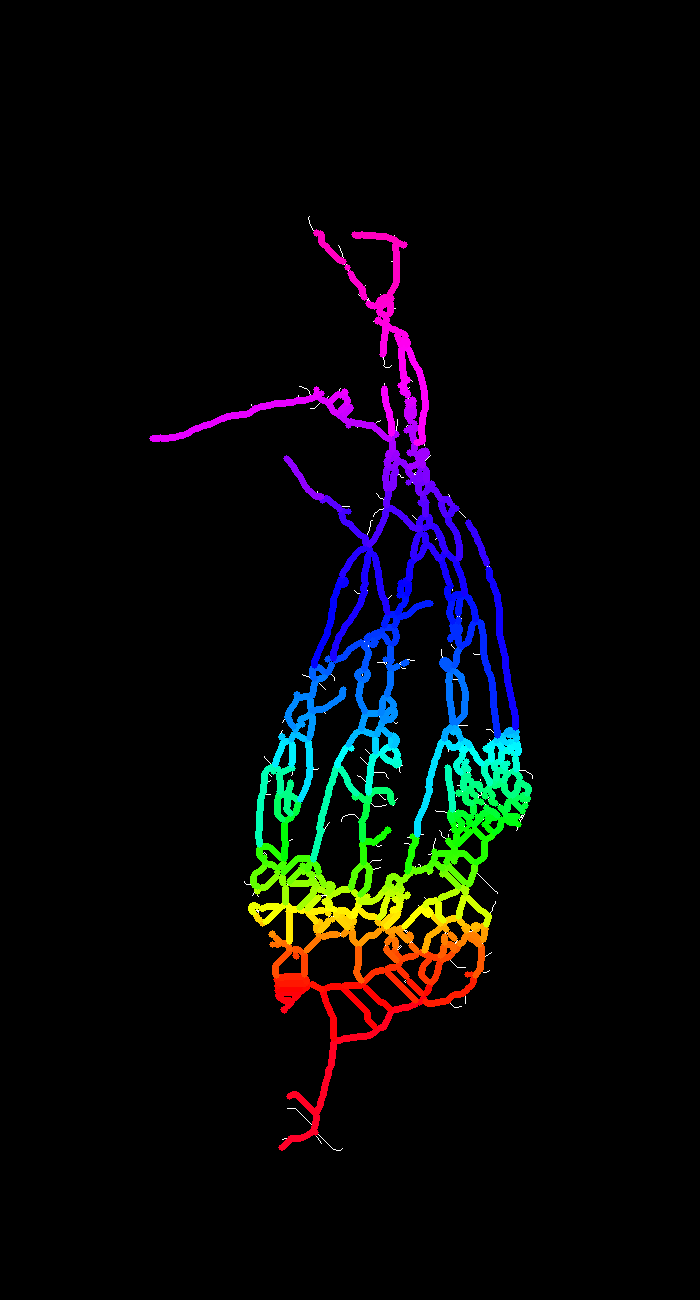

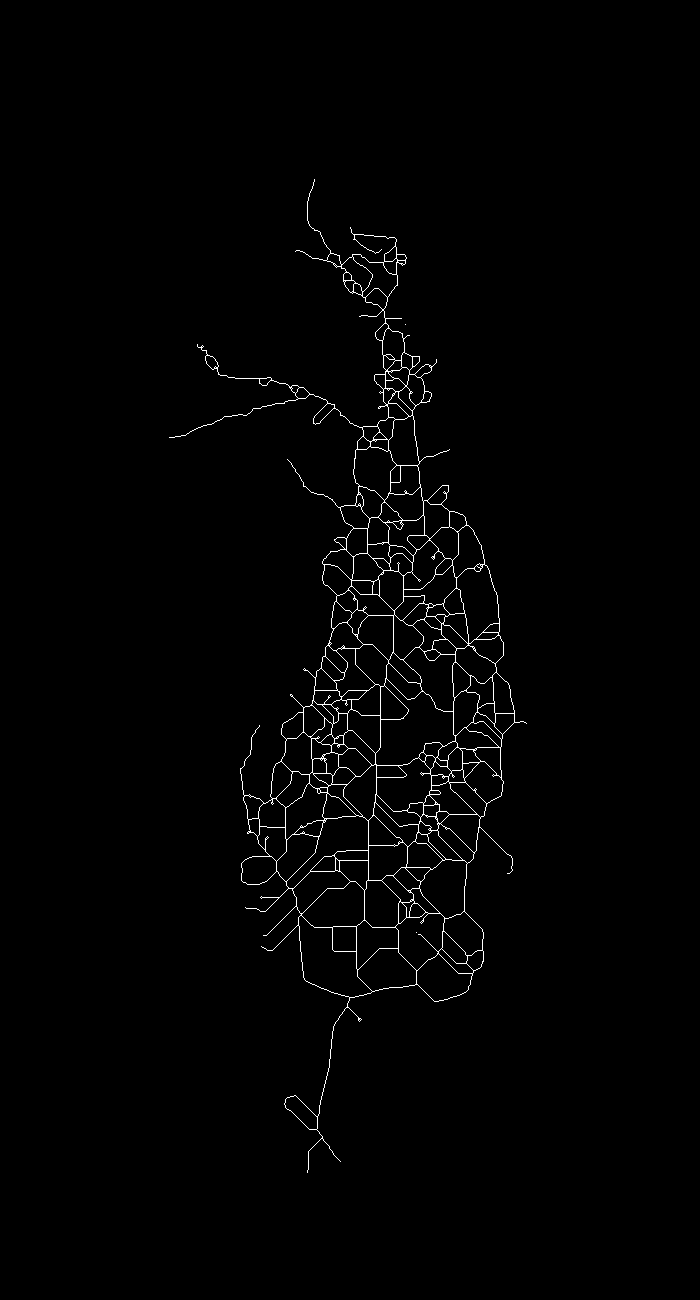

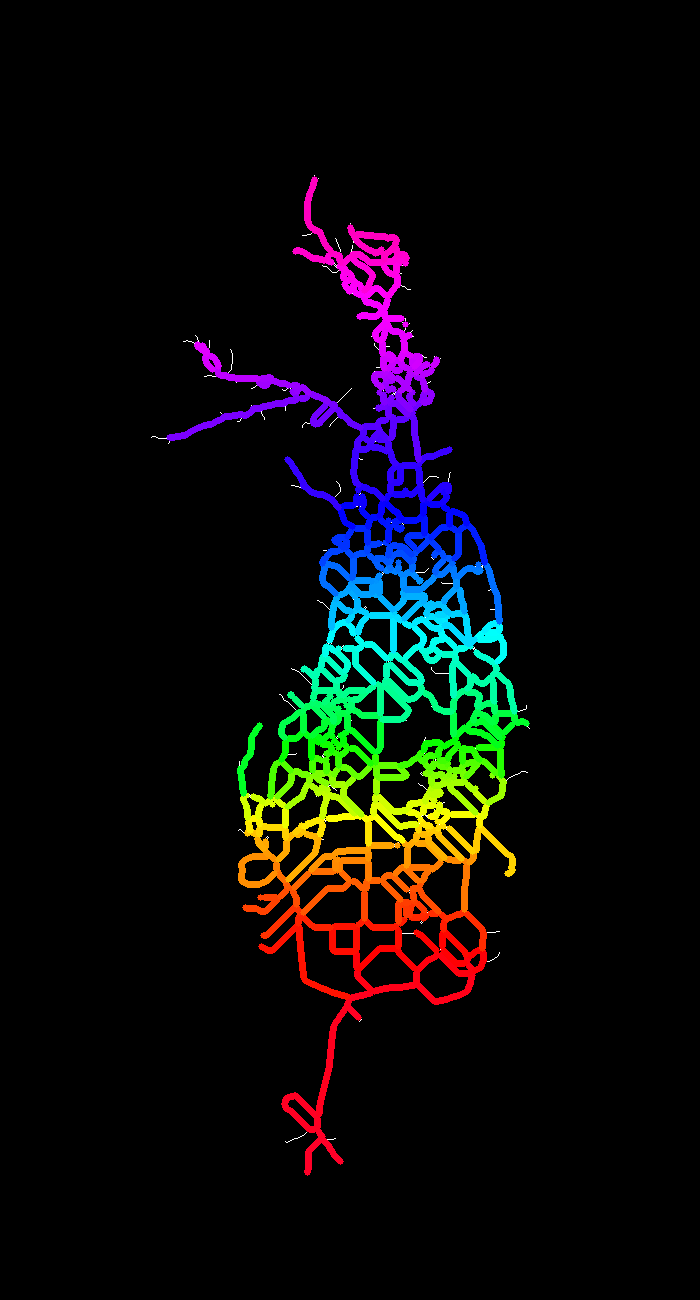

In [7]:
skeleton_low = pcv.morphology.skeletonize(mask=mask_fill_low)
pruned_skel_low, seg_img_low, edge_objects_low = pcv.morphology.prune(skel_img=skeleton_low, size=50, mask=skeleton_low)
img_disp(pruned_skel_low)
img_disp(seg_img_low)

skeleton_high = pcv.morphology.skeletonize(mask=mask_fill_high)
pruned_skel_high, seg_img_high, edge_objects_high = pcv.morphology.prune(skel_img=skeleton_high, size=50, mask=skeleton_high)
img_disp(pruned_skel_high)
img_disp(seg_img_high)

### Encontrar el tamaño
Para determinar el tamaño de la raíz, podemos utilizar la imagen binarizada para encontrar los contornos y luego calcular el área dentro de dichos contornos. También podemos ubicar un rectángulo alrededor de la raíz y encontrar la diagonal para medir la longitud. Esta forma de encontrar la longitud puede optimizarse en el futuro.


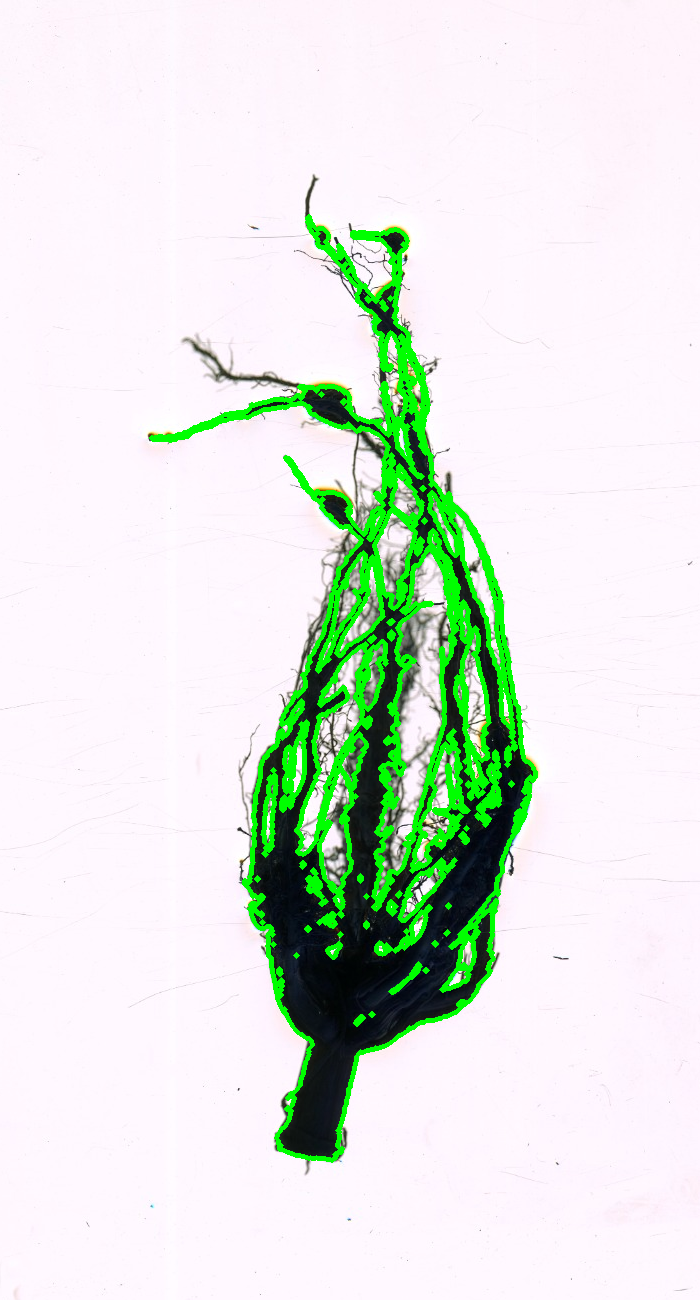

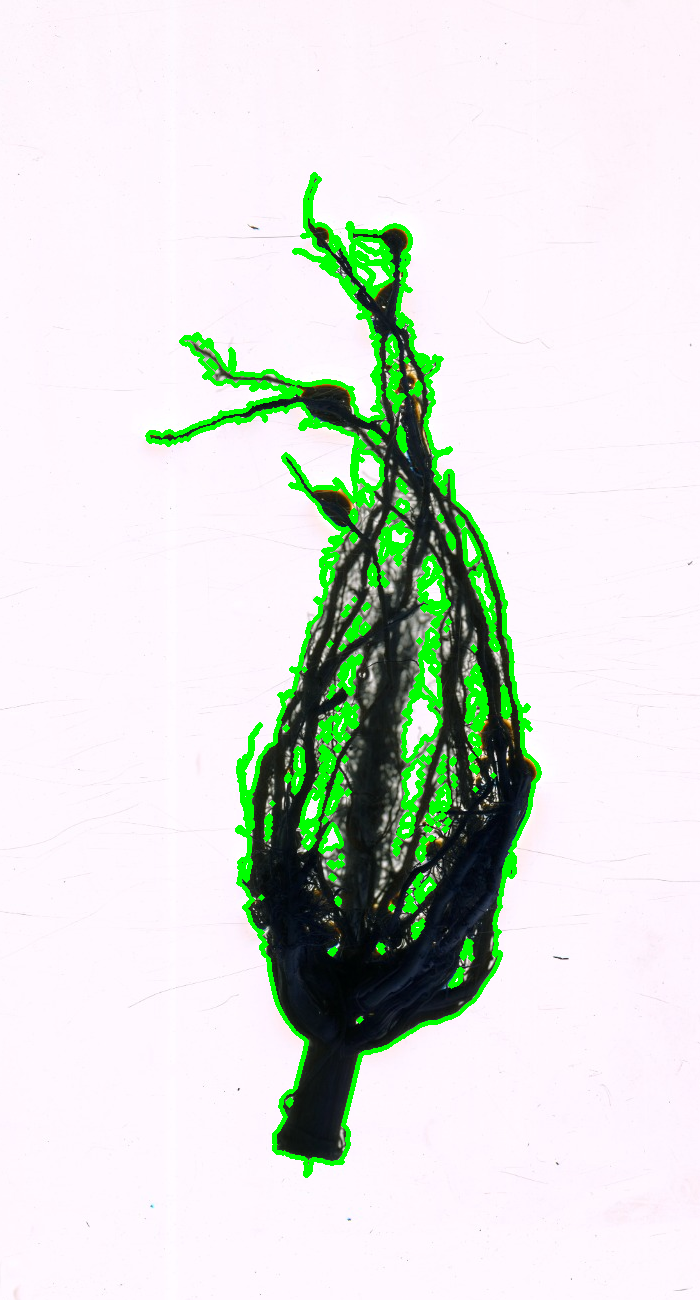

In [8]:
# Find the contours of the object  
contours_low, hierarchy = cv2.findContours(mask_fill_low, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
contours_high, hierarchy = cv2.findContours(mask_fill_high, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE) 
  
# Draw the contours on the original image
crop_img_low = crop_img.copy() 
cv2.drawContours(crop_img_low, contours_low, -1, (0,255,0), 3) 
crop_img_high = crop_img.copy() 
cv2.drawContours(crop_img_high, contours_high, -1, (0,255,0), 3) 
  
# Display the image with the contours drawn 
img_disp(crop_img_low)
img_disp(crop_img_high)

/var/folders/fx/l7m2ftt15p3fzw6vl0894hmh0000gn/T/ipykernel_438/241132614.py:4: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box_low = np.int0(box_low)


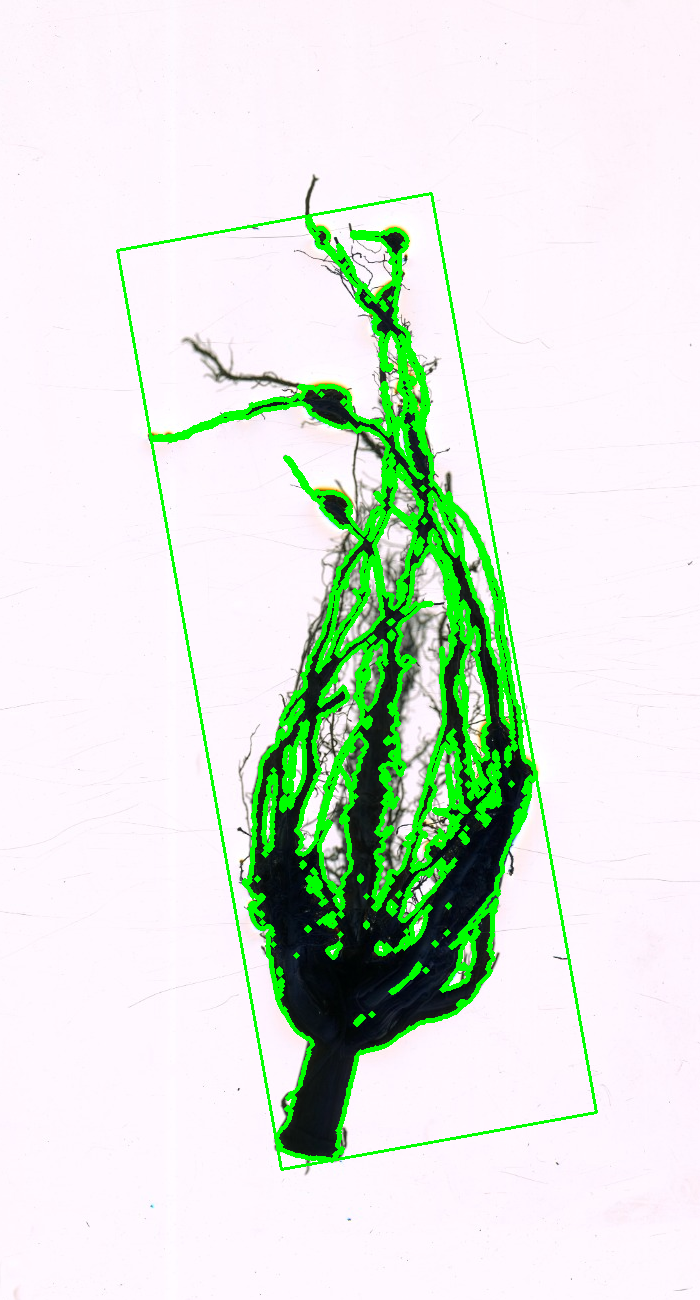

/var/folders/fx/l7m2ftt15p3fzw6vl0894hmh0000gn/T/ipykernel_438/241132614.py:14: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box_high = np.int0(box_high)


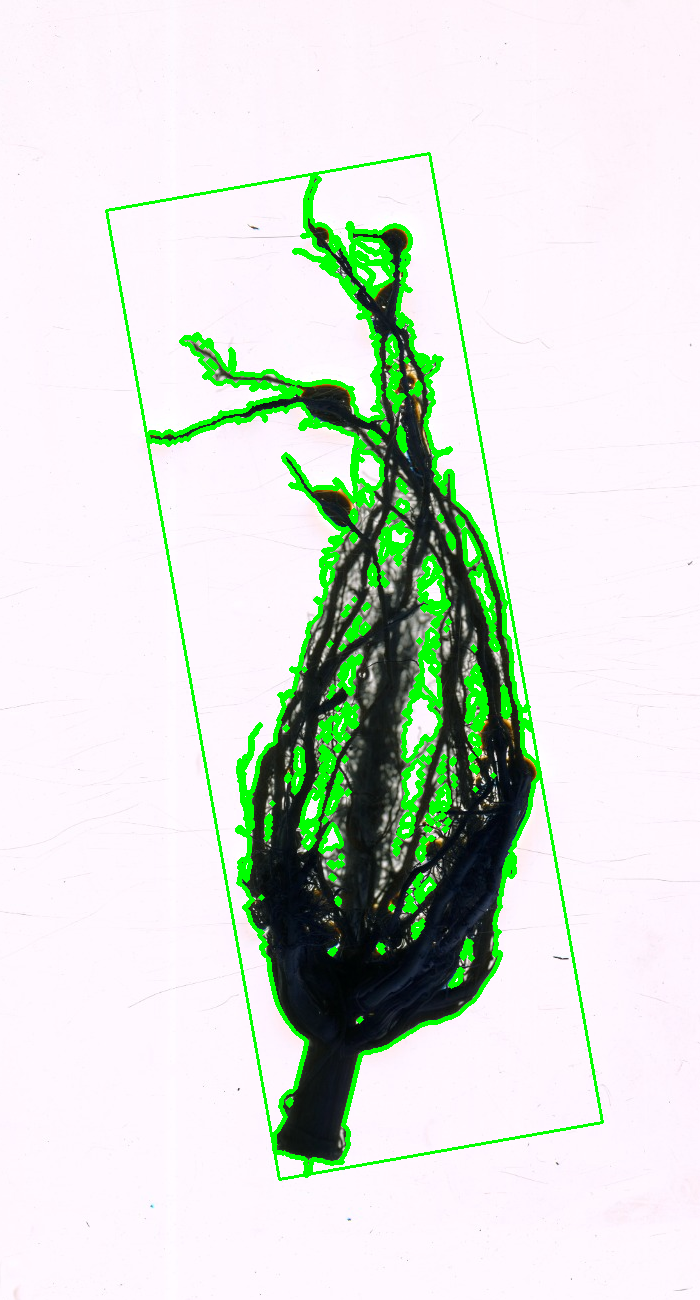

In [9]:
# Get rectangle around image
rect = cv2.minAreaRect(contours_low[0])
box_low = cv2.boxPoints(rect)
box_low = np.int0(box_low)

# Draw the rectangle on the image
cv2.drawContours(crop_img_low, [box_low], 0, (0, 255, 0), 2)  # (0, 255, 0) is the color (green), and 2 is the thickness

img_disp(crop_img_low)

# Get rectangle around image
rect = cv2.minAreaRect(contours_high[0])
box_high = cv2.boxPoints(rect)
box_high = np.int0(box_high)

# Draw the rectangle on the image
cv2.drawContours(crop_img_high, [box_high], 0, (0, 255, 0), 2)  # (0, 255, 0) is the color (green), and 2 is the thickness

img_disp(crop_img_high)

### Largo
El codigo encutra la distancia entre las dos esquinas de la imagen

In [10]:
# Calculate the diagonal size of the box
diagonal_size = np.linalg.norm(box_low[0] - box_low[2])
print(f"El tamaño de la raíz con un umbral bajo de binarización es de {round(diagonal_size,4)} px")

# Calculate the diagonal size of the box
diagonal_size = np.linalg.norm(box_high[0] - box_high[2])
print(f"El tamaño de la raíz con un umbral alto de binarización es de {round(diagonal_size,4)} px")

El tamaño de la raíz con un umbral bajo de binarización es de 986.1465 px
El tamaño de la raíz con un umbral alto de binarización es de 1038.1522 px


### Area
Cuenta el número de pixeles que no son 0

In [11]:
# Calculate the area of the selected contour
contour_area = cv2.contourArea(contours_low[0])
print(f"El area de la raíz con un umbral bajp de binarización es de: {contour_area} px^2")

# Calculate the area of the selected contour
contour_area = cv2.contourArea(contours_high[0])
print(f"El area de la raíz con un umbral alto de binarización es de: {contour_area} px^2")


El area de la raíz con un umbral bajp de binarización es de: 125428.0 px^2
El area de la raíz con un umbral alto de binarización es de: 149873.5 px^2
